<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка" data-toc-modified-id="Загрузка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#График-за-весь-период" data-toc-modified-id="График-за-весь-период-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>График за весь период</a></span></li><li><span><a href="#Распределение-нагрузки-по-времени" data-toc-modified-id="Распределение-нагрузки-по-времени-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Распределение нагрузки по времени</a></span></li><li><span><a href="#Анализ-остатков" data-toc-modified-id="Анализ-остатков-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Анализ остатков</a></span></li><li><span><a href="#Проверка-на-стационарность" data-toc-modified-id="Проверка-на-стационарность-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Проверка на стационарность</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Создание-новых-признаков" data-toc-modified-id="Создание-новых-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Создание новых признаков</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Построение-и-обучение-моделей" data-toc-modified-id="Построение-и-обучение-моделей-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Построение и обучение моделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Обший-вывод" data-toc-modified-id="Обший-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обший вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import warnings


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OrdinalEncoder,
    MinMaxScaler
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split,
    TimeSeriesSplit
)

from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

%matplotlib inline
sns.set_theme(style="darkgrid")
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="interval columns not set")

## Загрузка

Загрузим данные и заранее поставим отсортированное времени в качестве индексов

In [2]:
taxi_data_raw = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
taxi_data_raw.sort_index(inplace=True)

In [3]:
display(taxi_data_raw.head())
taxi_data_raw.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


В датасете всего 1 столбец без пропусков. Нам передали данные за период с марта по август(включительно) 2018-го года

Выполним ресемплирование данных по одному часу

In [4]:
taxi_data_res = taxi_data_raw.resample('1H').sum()

## Анализ

Проведём графический анализ данных, чтобы посмотреть, когда обычно происходит период пиковой нагрузки

### График за весь период

Добавим скользящее среднее для более наглядного просмотра активности пользователей. В качестве периода укажем 1 день, то есть интервал будет составлять 24 значения(размер окна).

In [5]:
taxi_data_res['rolling_mean'] = taxi_data_res.shift().rolling(24).mean()

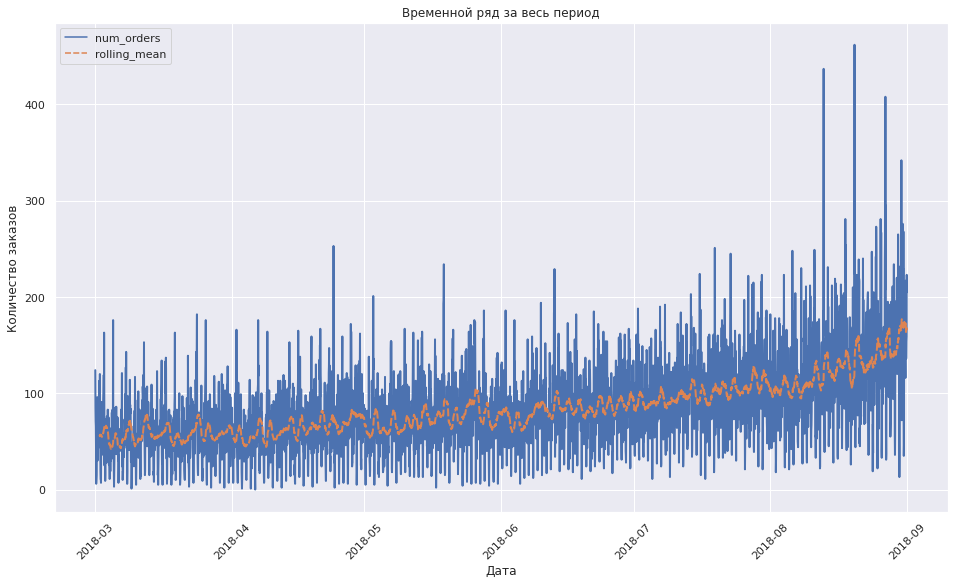

In [6]:
plt.figure(figsize=(16, 9))

sns.lineplot(data=taxi_data_res, linewidth=2.0, linestyle='-')

plt.title('Временной ряд за весь период')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.xticks(rotation=45)
plt.show();

**На графике:**

- заметно большое количество шумов, из-за чего его становится трудно читать
- много пиковых значений
- заметен постоянный тренд на повышение спроса с начала лета и до его конца
- в августе началось заметное ускорение спроса

### Распределение нагрузки по времени

Изучим недельную сезонность нагрузки

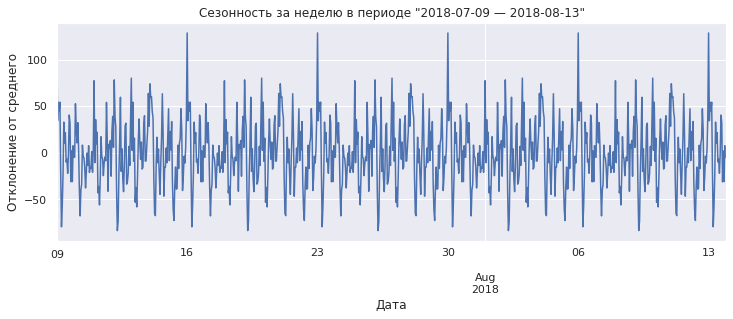

In [7]:
plt.figure(figsize=(12, 4))
decomposed_taxi_data_week = seasonal_decompose(
    taxi_data_res['num_orders']['2018-07-09':'2018-08-13'],# 9 августа - понедельник
    model='additive',
    period=168
)

 
decomposed_taxi_data_week.seasonal.plot(title='Сезонность за неделю в периоде "2018-07-09 — 2018-08-13"')
plt.xlabel('Дата')
plt.ylabel('Отклонение от среднего')
plt.show();

**Какие выводы можно сделать, взглянув на график cезонности по неделям:**

- На понедельник и субботу приходится самое малое количество заказов за неделю
- Во вторник, среду, четверг и пятницу количество заказов примерно одинаково
- Больше всего такси востребовано в воскресенье
- Пиковые значения достигаются под конец дня

А теперь взлянем на изменения cезонности заказов за обычный период в 7 дней, не включаюший праздники: 2018-08-13 — 2018-08-20

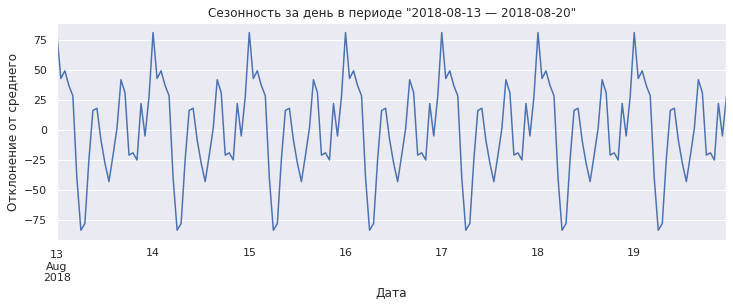

In [8]:
plt.figure(figsize=(12, 4))
decomposed_taxi_data_day = seasonal_decompose(
    taxi_data_res['num_orders']['2018-08-13':'2018-08-19'],
    model='additive',
    period=24
)

 
decomposed_taxi_data_day.seasonal.plot(title='Сезонность за день в периоде "2018-08-13 — 2018-08-20"')
plt.xlabel('Дата')
plt.ylabel('Отклонение от среднего')
plt.show();

**Какие выводы можно сделать, взглянув на график cезонности по дням:**

- Пиковые значения приходятся на ночь
- Минимальная активность происходит ранним утром
- Днём и вечером количество заказов остаётся средним

Рассмотрим подробнее активность клиентов в рамках одного дня, cгруппировав данные за всё время

In [9]:
taxi_data_res['hour'] = taxi_data_res.index.hour
hourly_pattern = taxi_data_res.groupby('hour')['num_orders'].mean()

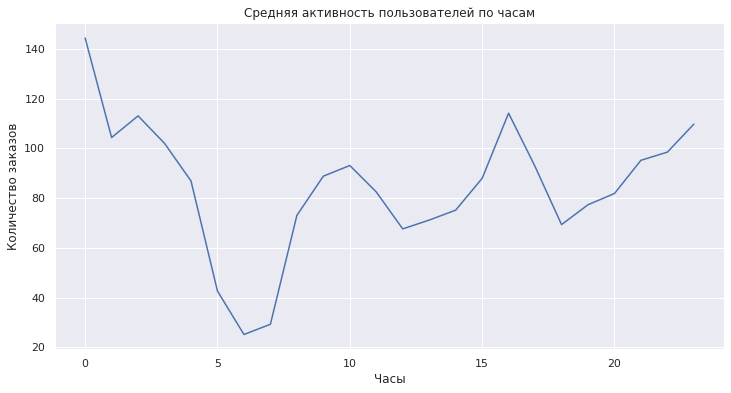

In [10]:
plt.figure(figsize=(12, 6))

taxi_data_res['hour'] = taxi_data_res.index.hour
hourly_pattern = taxi_data_res.groupby('hour')['num_orders'].mean()

hourly_pattern.plot()
plt.title('Средняя активность пользователей по часам')
plt.xlabel('Часы')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.show();

Таким образом, активность пользователей можно поделить на несколько периодов:

- Пиковая ночная нагрузка(с 22 до 4 часов)
- Утренний спад(с 4 до 8)
- Утренний подъём(с 7 до 12)
- Дневной подъём(с 12 до 16)
- Дневной пик(с 16 до 18)
- Вечерний поъём(с 18 до 22)

### Анализ остатков

Посмотрим на распределение остатков во временном ряде

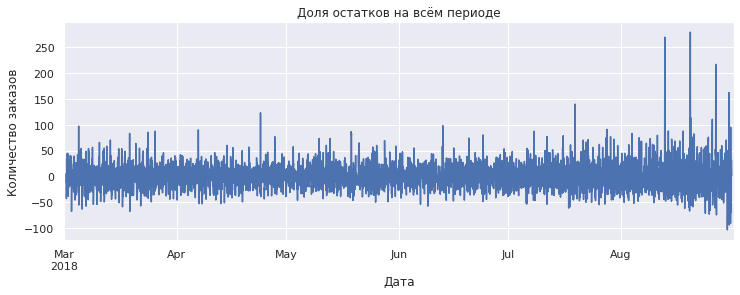

In [11]:
plt.figure(figsize=(12, 4))
decomposed_taxi_data = seasonal_decompose(
    taxi_data_res['num_orders'],
    model='additive',
    period=24
)

 
decomposed_taxi_data.resid.plot(title='Доля остатков на всём периоде')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show();

По графику видно, что во второй половине августа заметно большое количество выбивающихся значений(шумов), по сравнению с остальным временем. Такое распределение остатков может привести к тому, что модели будет тяжело предсказывать будущие значения на тестовых данных корректно(может привести к значительно разнице в качестве предсказаний на валидационной и тестовой выборках)

### Проверка на стационарность

Перед построением модели временной ряд следует проверить на стационарность. Такие ряды легче предсказывать и интерпретировать

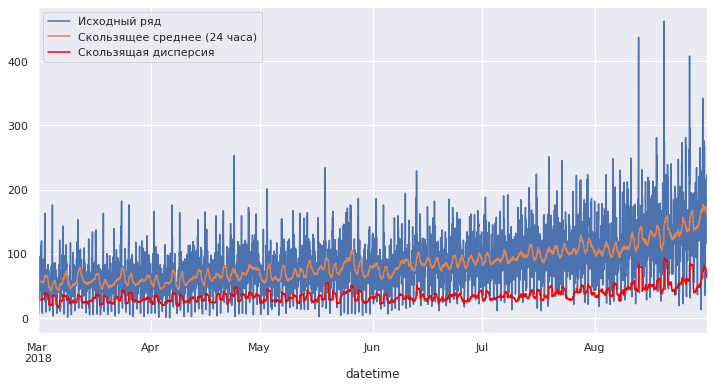

In [12]:
plt.figure(figsize=(12, 6))

taxi_data_res['num_orders'].plot(label='Исходный ряд')
taxi_data_res['num_orders'].rolling(window=24).mean().plot(label='Скользящее среднее (24 часа)')
taxi_data_res['num_orders'].rolling(window=24).std().plot(label='Скользящая дисперсия', color='red')
plt.legend()
plt.grid(True)
plt.show()

Скользящее среднее и дисперсия колеблются вокруг константы, однако всё же имеют тренд на повышение

Тогда воспользуемся статистическим тестом Дики-Фуллера

In [13]:
result = adfuller(taxi_data_res['num_orders'])
print('ADF статистика:', result[0])
print('p-value:', result[1])

ADF статистика: -3.0689242890279558
p-value: 0.028940051402612906


p-value оказался довольно малым(меньше 0.05, например), а значит, можно считать ряд достаточно стационарным

В строгом смысле наш ряд не является стационарным, потому что имеет не только тренд, но еще и с августа - ускорение.
Протестируем, можно ли привести ряд к стационарному виду

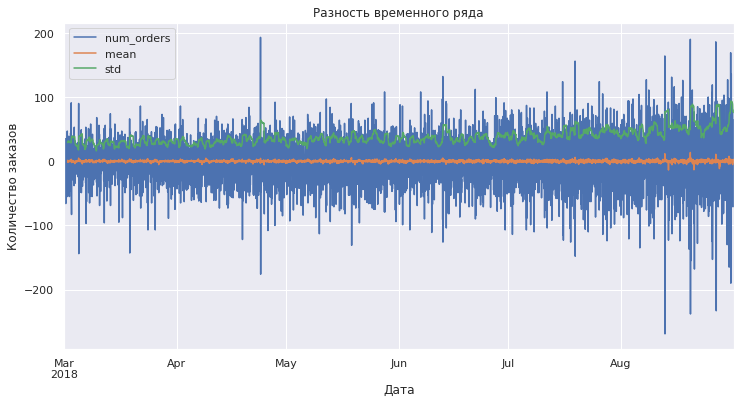

In [14]:
stac_data = (
    taxi_data_res
    .copy()
    .drop(['hour', 'rolling_mean'], axis=1)
)

stac_data['num_orders'] = stac_data['num_orders'] - stac_data['num_orders'].shift()
stac_data['mean'] = stac_data['num_orders'].rolling(24).mean()
stac_data['std'] = stac_data['num_orders'].rolling(24).std()
stac_data.plot(figsize=(12, 6), xlabel='Дата', ylabel='Количество заказов', title='Разность временного ряда')
plt.show();

Как можно заметить, ряд стал более стационарным, а значит с такие данные можно прогнозировать

**В результате анали временного ряда было выявлено, что:**

- Исходный ряд имеет постоянный тренд на повышение, а также обладает большим количеством шумов и пиковых значений
- С августа началость быстрое ускорение спроса на такси
- Самые загруженный день - воскресенье, а самые незагруженные дни - понедельник и суббота
- Активность пользователей неравномерна: ночью и в 16 и 17 часов нагрузка пиковая
- С начала второй половины августа в данных присутствует большое количество шумов, что может плохо сказаться на качестве предсказаний
- Временной ряд стационарен, а значит, моделям будет легче обучаться

## Обучение

### Создание новых признаков

Создадим признаки для горизонта прогнозирования в один шаг

In [15]:
# функция возвращает датасет с новыми признаками: месяц, день, день недели и отстающее значение
def make_features(data, max_lag, rolling_mean_size):
    res_df = data.copy()
    res_df['day'] = data.index.day
    res_df['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        res_df['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    res_df['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return res_df

In [16]:
taxi_data = make_features(taxi_data_res, 7, 24)
taxi_data.head(10)

,num_orders,rolling_mean,hour,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,0,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,2,1,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,4,1,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 05:00:00,6,NaN,5,1,3,43.0,66.0,71.0,85.0,124.0,NaN,NaN
2018-03-01 06:00:00,12,NaN,6,1,3,6.0,43.0,66.0,71.0,85.0,124.0,NaN
2018-03-01 07:00:00,15,NaN,7,1,3,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-01 08:00:00,34,NaN,8,1,3,15.0,12.0,6.0,43.0,66.0,71.0,85.0


Избавимся от появившихся пропущенных значений

In [17]:
taxi_data.dropna(inplace=True)

### Подготовка

Подготовим данные для корректной работы наших моделей

In [18]:
RANDOM_STATE=42

X, y = taxi_data.drop(['num_orders'], axis=1), taxi_data['num_orders']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=0.1
)

In [19]:
num_cols = ['rolling_mean', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7']
ord_cols = ['hour', 'day', 'dayofweek']

Построим пайплайн для подготовки категориальных данных

### Построение и обучение моделей

В качестве метрики будем использовать RMSE для придачи важности ошибкам и получения значения ошибок в единицах предсказания

Для предсказания временных рядов будем использовать продвинутые модели: LightGBM, CatBoost, Random Forest

Начнём с модели случайного леса

In [20]:
data_preprocessor1 = ColumnTransformer(
    [
     ('num', MinMaxScaler(), num_cols)
    ], 
    remainder='passthrough'
)

rf_pipe = Pipeline([
    ('preprocessor', data_preprocessor1),
    ('rf', RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=300))
])

In [21]:
rf_params = {
    'rf__min_samples_leaf': range(1, 3),
    'rf__min_samples_split': range(2, 6, 2),
    'rf__max_depth':range(4, 9, 2),
    'rf__max_features': range(3, len(num_cols+ord_cols))
}

При работе с временными рядами будем использовать TimeSeriesSplit, чтобы не перемешивать тренировочные и валидационные данные

In [22]:
tscv = TimeSeriesSplit(n_splits=5)

In [23]:
rf_search = RandomizedSearchCV(
    rf_pipe,
    rf_params,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

rf_search.fit(X_train, y_train)
print('Параметры модели:', rf_search.best_params_)
print('RMSE модели:', -rf_search.best_score_)

Параметры модели: {'rf__min_samples_split': 4, 'rf__min_samples_leaf': 2, 'rf__max_features': 7, 'rf__max_depth': 8}
RMSE модели: 26.339130447781475


Неплохой результат

Теперь посмотрим, как градиентные бустинги справятся с предсказанием. Начнём с LGBM

In [24]:
lgbm_pipe = Pipeline([
    ('preprocessor', data_preprocessor1),
    ('lgbm', LGBMRegressor(random_state=RANDOM_STATE, n_estimators=10))
])

lgbm_params = {
    'lgbm__learning_rate': [0.01, 0.1],
    'lgbm__max_depth':range(4, 9, 2)

}

In [25]:
lgbm_search = GridSearchCV(
    lgbm_pipe,
    lgbm_params,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

lgbm_search.fit(X_train, y_train)
print('Параметры модели:', lgbm_search.best_params_)
print('RMSE модели:', -lgbm_search.best_score_)

Параметры модели: {'lgbm__learning_rate': 0.1, 'lgbm__max_depth': 8}
RMSE модели: 29.502660776134938


Пришло время для CatBoost показать себя

In [26]:
catboost_pipe = Pipeline([
    ('preprocessor', data_preprocessor1),
    ('catboost', CatBoostRegressor(random_state=RANDOM_STATE,
                                   n_estimators=300,
                                   verbose=0)
    )
])

cat_feature_indices_after_transform = list(range(len(num_cols), len(num_cols) + len(ord_cols)))

for col in ord_cols:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)
    
catboost_params = {
    'catboost__learning_rate': [0.01, 0.1],
    'catboost__max_depth':range(4, 9, 2)

}  

In [ ]:
catboost_search = GridSearchCV(
    catboost_pipe,
    catboost_params,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)


catboost_search.fit(X_train, y_train, catboost__cat_features=cat_feature_indices_after_transform)
print('Параметры модели:', catboost_search.best_params_)
print('RMSE модели:', -catboost_search.best_score_)

СatBoost показал себя лучше всех

**В результате**, получается, что лучшая модель - СatBoost

## Тестирование

Посмотрим, как лучшая модель покажет себя на тестовых данных

In [ ]:
y_pred = catboost_search.predict(X_test)
print('RMSE лучшей модели:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('Параметры лучшей модели:', catboost_search.best_params_)

Удивительно большое отклонение от RMSE на тренировочных данных. Видно, тестовые данные также включали в себя большое количество шумов, как и значения после середины августа

Построим график, чтобы сравнить предсказания лучшей модели и реальные значения

In [ ]:
testing_df = pd.DataFrame({
    'Реальные значения': y_test,
    'Предсказанное количество заказов': y_pred}
)

In [ ]:
plt.figure(figsize=(16, 9))

sns.lineplot(data=testing_df, linewidth=2.0, linestyle='-')

plt.title('Временной ряд тестовых данных')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.xticks(rotation=45)
plt.show();

По графику заметно, что модели удается предсказывать нагрузку на сервис - она довольно четко улавливает тренд, но не справляется с предсказанием постоянно появляющихся высоких значений. Этого может быть достаточно для привлечения водителей в периоды пиковой нагрузки. Этого можно было бы избежать, если бы в данных было меньше шума или при большем объёме датасета

Проверим модель на адекватность с помощью DummyRegressor

In [ ]:
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)

y_pred_ = dummy.predict(X_test)
print('RMSE тривиальной модели:', np.sqrt(mean_squared_error(y_test, y_pred_)))

Наша модель предсказывает в 2 раза точнее среднего значения

Таким образом, полученная Сatboost модель в среднем ошибается на 41 заказ. Она обладает параметрами: 'learning_rate': 0.1, 'n_estimators': 300, 'max_depth': 6.

## Обший вывод

**В ходе работы:**

- Загруженные данные были ресемплированы по часам
- Был проанализирован временной ряд
    - Был обнаружен тренд на повышение количества заказов
    - Было определено время пиковой нагрузки(ночью, в 16 и 17 часов)
    - В ходе анализа остатков была замечено большое количество шумов к концу периода
    - Была подтверждена стационарность данных
    
- Были созданы новые признаки на основе данных 
- Было обучено 3 регрессионные модели, среди которых лучшей оказалась модель CatBoostRegressor('learning_rate': 0.1, 'n_estimators': 300, 'max_depth': 6) Её ошибка предсказания составляет в среднем 41 заказа